# Projet Cnes

#### Importation des librairies

In [1]:
from scipy.optimize import minimize
import numpy as np
import math
from random import choices
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
import matplotlib.image as mpimg

## Définition des lois et création des points

#### Densité de probabilité d'une loi GGA (pour un scalaire et un array)

In [2]:
def f(x, parametres, seuil=10**(-6)):
    """
    fonction de densité d'une gaussienne généralisée asymétrique
    :param x: float ou int
    :param parametres: list de 5 paramètres, paramètres = [alpha, lambda, gamma, mu]
    :return: f(x), la densité de probabilité au point x
    """
    alpha, lambd, gamma, mu = parametres
    delta = (2*(alpha**lambd)*(1-alpha)**lambd)/(alpha**lambd+(1-alpha)**lambd)
    A = (delta**(1/lambd))/(gamma**(1/lambd)*math.gamma(1+1/lambd))
    B = (-(delta/gamma)*(np.abs(mu-x))**lambd)
    if x < mu:
        p = A*np.e**(B/(alpha**lambd))
    else:
        p = A*np.e**(B/((1-alpha)**lambd))
    return max([p, seuil])

def f_array(X, parametres):
    """
    pareil que f mais avec des array
    :param X: array
    :param parametres:
    :return:
    """
    n = len(X)
    Y = np.zeros(n)
    for i in range(n):
        Y[i] = f(X[i], parametres)
    return Y


def f_tot(x, param, poids):
    """
    fonction de répartition totale, avec les différentes classes
    :param f: support de la fonction de prob
    :param param: dictionnaire, avec les paramètres de chaque fonction et leur poids
    :return: f_tot, la fonction de densité totale
    """
    m = len(param)
    p = 0
    for i in range(m):
        p += poids[i]*f(x, param[i])
    return p


def f_array_tot(X, parametres, poids):
    """
    pareil que f_tot mais avec des array
    :param X: array
    :param parametres:
    :return:
    """
    n = len(X)
    Y = np.zeros(n)
    for i in range(n):
        Y[i] = f_tot(X[i], parametres, poids)
    return Y


#####  Fonction d'importation de l'image

In [3]:
def X_image(file):
    """

    :param file:
    :return:
    """
    img = mpimg.imread(file)

    if img.dtype == np.float32:  # Si le résultat n'est pas un tableau d'entiers
        img = (img * 255).astype(np.uint8)

    plt.imshow(img)
    plt.show()
    #
    # print(img)
    # print(img.shape)

    X = []
    for i in range(img.shape[0]):
        X += list(img[i])

    # print(X)
    # print(len(X))
    return X, img.shape


#### Importation de l'image

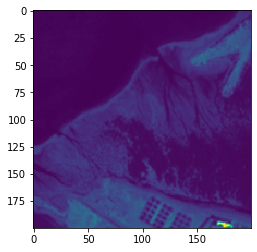

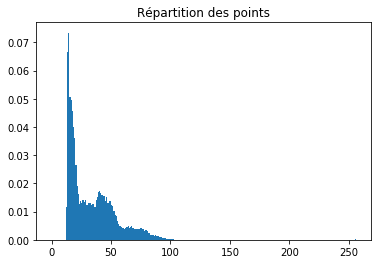

In [4]:
file = "image2.png"
X_ech, shape = X_image(file)
plt.hist(X_ech, 256, density=True, range=(0, 256), histtype='barstacked')
plt.title('Répartition des points')
plt.savefig('Image_2/repartition_points')
plt.show()
n = len(X_ech)

## Mise en place de l'algorithme EBM

#### Fonction de la log-vraissemblance

In [5]:
def log_vraiss(theta, X):
    """
    return la log-vraissemblance de la fonction normale
    :param theta: theta = [alpha, lambda, gamma, mu]
    :param X: array
    :return:
    """
    n = len(X)
    alpha, lambd, gamma, mu = theta
    delta = (2*(alpha**lambd)*(1-alpha)**lambd)/(alpha**lambd+(1-alpha)**lambd)
    A = (delta**(1/lambd))/(gamma**(1/lambd)*math.gamma(1+1/lambd))

    log = n*np.log(A)
    for i in range(n):
        B = (-(delta/gamma)*(np.abs(mu-X[i]))**lambd)
        if X[i] < mu:
            C = B/(alpha**lambd)
        else:
            C = B/((1-alpha)**lambd)
        log += C
    return -log

#### Fonction d'affichage des données

In [6]:
def affiche_2(X, P, title=None):
    M = len(P[0])
    x = [[] for k in range(M)]
    for i in range(len(X)):
        x[P[i].index(1)].append(X[i])
    for j in range(M):
        x[j] = np.array(x[j])
    plt.hist(x, 256, density=True,range=(0, 256), histtype='barstacked')
    plt.title(title)
    return None

#### Fonction d'écriture des paramètres

In [7]:
def affichage_param(param):
    for i in range(len(param)):
        print('Classe {0}: alpha= {1}, lambda= {2}, gamma= {3}, mu= {4}'.format(i+1, param[i][0], param[i][1], param[i][2], param[i][3]))

#### Fonction d'initialisation

In [8]:
def init_EM(M, X, method="kmeans"):
    """
    initialise M lois GGA
    :param M: entier, nombre de classe
    :param X: échantillon
    :param method: "kmeans" (par défaut) ou "spectral"
    :return: param, matrice de M lignes, et 4 colonnes: alpha, lambda, gamma, mu
    """
    n = len(X)
    X_df = pd.DataFrame(X)
    means = []
    model = None
    clusters = [[] for k in range(M)]

    if method == "kmeans":
        model = KMeans(n_clusters=M, random_state=0).fit(X_df)
        means = model.cluster_centers_
    elif method == "spectral":
        model = SpectralClustering(n_clusters=M, assign_labels="kmeans", random_state=0).fit(X_df)

    labels = model.labels_
    # reconstruction des clusters
    for k in range(len(labels)):
        clusters[labels[k]].append(X[k])

    # on crée la matrice P qui donne l'appartenance de chaque pixel aux différentes classes:

    P = [M*[0] for i in range(n)]
    for i in range(n):
        P[i][labels[i]] = 1

    # calcul des moyennes pour le cas du spectral clustering
    if method == "spectral":
        for k in range(M):
            S = 0
            for e in clusters[k]:
                S += e
            means.append(S/len(clusters[k]))

    # il reste à calculer gamma
    gamma = [0]*M
    # calcul de gamma
    # inutile ici, ça se simplifie pour alpha=1/2 et lambda=2
    sigma = 1/4
    for i in range(M):
        l = len(clusters[i])
        K = 0
        mu = means[i]
        for x in clusters[i]:
            if x >= mu:
                K += (x-mu)
            else:
                K += (mu-x)
        gamma[i] = 2*K/l
    
    param = [[1/2, 2, gamma[i][0], means[i][0]] for i in range(M)] # on prend des valeurs arbitraires pour alpha et lambda 
    return param, P

Classe 1: alpha= 0.5, lambda= 2, gamma= 4.544147698320141, mu= 16.200666590045834
Classe 2: alpha= 0.5, lambda= 2, gamma= 5.821507071320033, mu= 50.687524140594434
Classe 3: alpha= 0.5, lambda= 2, gamma= 7.8218424556861015, mu= 66.37476670399364
Classe 4: alpha= 0.5, lambda= 2, gamma= 5.961314387301807, mu= 28.422740987771995
Classe 5: alpha= 0.5, lambda= 2, gamma= 64.34741225461032, mu= 211.1219512195122
Classe 6: alpha= 0.5, lambda= 2, gamma= 11.609377535016916, mu= 83.01219512195092
Classe 7: alpha= 0.5, lambda= 2, gamma= 5.17354200139744, mu= 40.16169116532707


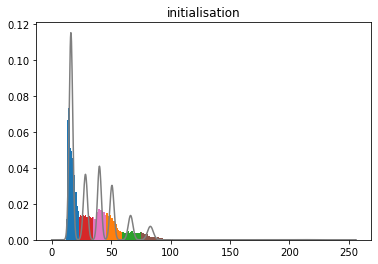

In [9]:
M = 7 # nombres de classes
param, P0 = init_EM(M, X_ech)
affichage_param(param)
affiche_2(X_ech, P0, title='initialisation')
poids = M*[0]
for j in range(n):
    poids[int(P0[j].index(1))] += 1
for j in range(M):
    poids[j] /= n
x = np.linspace(0, 256, 1000)
y = f_array_tot(x, param, poids)
plt.plot(x, y)
plt.savefig('Image_2/initialisation')
plt.show()

#### Fonction de l'étape E

In [10]:
def etape_E(X, M, param):
    """
    Calcul de la matrice P, avec les proba que les x appartiennent à chaque classe
    :param X: echantillon
    :param M: nombre de classe
    :param param: paramètres initiaux
    :return: une matrice de taille len(X)*M avec pi,j la proba que xi vienne de la distribution fi
    """
    P = [M*[0] for i in range(len(X))]
    for i in range(len(X)):
        x = X[i]
        tot = 0
        for j in range(M):
            P[i][j] = f(x, param[j])
            tot += P[i][j]
        for j in range(M):
            P[i][j] = P[i][j]/tot
    return P

#### Fonction de l'étape B

In [11]:
def etape_B(X, M, P):
    """
    Etape B, attribue les pixels à une et unique classe, celle dont leur probabilité d'appartenir est la plus grande.
    :param X: Échantillon
    :param M: nombre de classe
    :param param: paramètres des lois
    :param P: Matrice des propabilité d'appartance de chaque point à chaque point (cf output etape_E)
    :return: matrice P, avec des 1 à la probabilité la plus importante.
    """
    n = len(X)
    for i in range(n):
        a = np.random.multinomial(20, P[i])
        P[i] = M*[0]
        P[i][np.argmax(a)] = 1
    return P

#### fonction de l'étape M

In [12]:
def etape_M(X, M, param, P):
    A = [[] for k in range(M)]
    for i in range(len(X)):
        for j in range(M):
            if P[i][j] == 1:
                A[j].append(X[i])
    for i in range(M):
        # print("\n \n----- Classe {} -----\n \n".format(i+1))
        param[i] = maxim(param[i], A[i], methode)
    return param

#### Fonction de maximisation de la log-vraissemblance

In [13]:
def maxim(theta_0, X, methode):
    res = minimize(log_vraiss, theta_0, args=X, method=methode, bounds=((0.001, 0.99), (0.5, 3), (0, 10), (None, None)),
                   tol=None, options={'disp': True, 'ftol': 1e-3})
    theta_f = res.x
    return theta_f

#### Fonction d'arrêt de l'EBM

In [14]:
def arret(P1, P2, param1, param2, k, m=4, crit=0.01):
    """fonction pour décider de l'arrêt des itérations
    :param P1 : une 1ere matrice P
    :param P2 : une 2eme matrice P
    :param param1 : une 1ere liste de liste de paramètres param
    :param param2 : une 2eme liste de liste de paramètres param
    :param k : nombre de différences maximales souhaitées dans les matrices P successives pour arrêter les itérations
    :param m : nombre de différences maximales souhaitées dans les listes de paramètres successives pour arrêter les itérations
             (par défaut 0, on arrête quand les paramètres ne bougent plus)
    :param crit : norme maximale en dessous de laquelle deux listes de paramètres sont décidées égales (par défaut 10^(-3))
    """
    diff_P = 0
    n = len(P1)
    for i in range(n):
        if P1[i] != P2[i]:
            diff_P += 1

    l = len(param1)
    diff_param = 0
    for i in range(l):
        d = 0
        for j in range(4):
            d += abs(param1[i][j]-param2[i][j])/param1[i][j]
        if d >= crit:
            diff_param += 1
    print('diff_P = {}, diff_param = {}'.format(diff_P, diff_param))

    return diff_P <= k and diff_param <= m

### Réalisation de l'algorithme sur les données


 
 --------------- Etape M n°1 ---------------
 
diff_P = 818, diff_param = 7


Classe 1: alpha= 0.2840588472842828, lambda= 1.335296534797218, gamma= 4.438227678440705, mu= 14.07825628490381
Classe 2: alpha= 0.27203612773792535, lambda= 1.3370031923256764, gamma= 5.780707532887875, mu= 48.007956506555075
Classe 3: alpha= 0.1794600396123651, lambda= 1.6812254028767009, gamma= 7.899010926121692, mu= 60.65509714239761
Classe 4: alpha= 0.1816107263745338, lambda= 1.6440411081132897, gamma= 6.022874500852853, mu= 23.930654451117203
Classe 5: alpha= 0.08694682536774728, lambda= 1.0387240726708429, gamma= 9.965395417995781, mu= 95.16544312285026
Classe 6: alpha= 0.18061678290346422, lambda= 1.6675281193992582, gamma= 9.999956282877834, mu= 75.86389225216814
Classe 7: alpha= 0.2832605178728517, lambda= 1.350228584737362, gamma= 5.170791988314866, mu= 38.14144322885364

 
 --------------- Etape M n°2 ---------------
 
diff_P = 1224, diff_param = 7


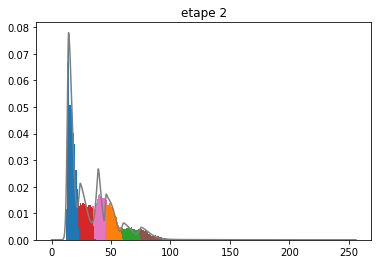

Classe 1: alpha= 0.26221446254393405, lambda= 1.6782009402248261, gamma= 3.7072834875050433, mu= 14.295174062991176
Classe 2: alpha= 0.1392696542943283, lambda= 2.9478081653934485, gamma= 5.813810270236464, mu= 46.40017206472075
Classe 3: alpha= 0.19743096166021143, lambda= 1.7178445239545883, gamma= 7.692158066571752, mu= 60.631319746434166
Classe 4: alpha= 0.20700759827039478, lambda= 1.667408085300282, gamma= 5.98359285436718, mu= 24.289572543914787
Classe 5: alpha= 0.16310178192077449, lambda= 0.9781100762054221, gamma= 9.639728236541838, mu= 94.77216843845412
Classe 6: alpha= 0.21407993704258393, lambda= 1.6962279312444883, gamma= 9.964045475665053, mu= 75.68007143063136
Classe 7: alpha= 0.4026412389004198, lambda= 1.4467924035840793, gamma= 5.264318408422828, mu= 39.33667778065742

 
 --------------- Etape M n°3 ---------------
 
diff_P = 1291, diff_param = 6


Classe 1: alpha= 0.2525592995763255, lambda= 1.6813888686129692, gamma= 3.7088358676653956, mu= 14.03029591821708
Classe 2: alpha= 0.13921605277303561, lambda= 2.9480080183003317, gamma= 5.81611722529511, mu= 46.132082780909975
Classe 3: alpha= 0.2009867494185121, lambda= 1.7272962667327136, gamma= 7.65320659224142, mu= 60.35871829657282
Classe 4: alpha= 0.20671585746462337, lambda= 1.6692952556873115, gamma= 5.989280750672029, mu= 24.122396484913207
Classe 5: alpha= 0.19737213319882527, lambda= 0.9646792012684676, gamma= 8.28162916502252, mu= 91.11719598887763
Classe 6: alpha= 0.14602195353151867, lambda= 2.3821421694552964, gamma= 9.758158684873463, mu= 74.13921753401826
Classe 7: alpha= 0.40658602259863086, lambda= 1.4615004956262037, gamma= 5.256628653897603, mu= 39.157460352436196

 
 --------------- Etape M n°4 ---------------
 
diff_P = 846, diff_param = 3


In [15]:
methode = 'L-BFGS-B'
k = 3500  #  Nombre de points qui doivent changer pour la fonction d'arrêt
P_prec = P0
param_prec = param[:]
i = 0

while True:
    i += 1
    P0 = etape_E(X_ech, M, param)
    P = etape_B(X_ech, M, P0)
    print("\n \n --------------- Etape M n°{} ---------------\n ".format(i))
    param = etape_M(X_ech, M, param, P)
    if arret(P_prec, P, param_prec, param, k):
        break
    else:
        plt.clf()
        P_prec = P
        param_prec = param[:]
        affiche_2(X_ech, P, title='etape {}'.format(i))
        poids = M*[0]
        for j in range(n):
            poids[int(P[j].index(1))] += 1
        for j in range(M):
            poids[j] /= n
        x = np.linspace(0, 256, 1000)
        y = f_array_tot(x, param, poids)
        plt.plot(x, y)
        plt.savefig('Image_2/etape_{}'.format(i))
        plt.show()
        affichage_param(param)

## Affichage des résultats

In [16]:
affichage_param(param)
plt.clf()
poids = M*[0]
for j in range(n):
    poids[int(P[j].index(1))] += 1
for j in range(M):
    poids[j] /= n
x = np.linspace(0, 256, 1000)
y = f_array_tot(x, param, poids)
plt.plot(x, y)
affiche_2(X_ech, P, title='etape {}'.format(i))
plt.savefig('Image_2/etape_finale')
plt.show()

print("Nombre d'étapes :", i)

X_classe = [int(P[k].index(1)*255/M) for k in range(len(X_ech))]

image_finale = np.zeros(shape)
for k in range(shape[0]):
    image_finale[k] = np.array(X_classe[k*shape[1]:(k+1)*shape[1]])

plt.imshow(image_finale)
plt.title('image finale')
plt.savefig('Image_2/Image_finale')
plt.show()

Classe 1: alpha= 0.2529441639648842, lambda= 1.6820770411894712, gamma= 3.706900255964477, mu= 14.056827781080457
Classe 2: alpha= 0.1398175524395954, lambda= 2.9480447763512543, gamma= 5.812005261754789, mu= 46.04403108584863
Classe 3: alpha= 0.19737616882172745, lambda= 1.7491917201557219, gamma= 7.636076668522038, mu= 59.99350328259605
Classe 4: alpha= 0.20635693226572926, lambda= 1.671617018680735, gamma= 5.99627850097682, mu= 23.993659011547773
Classe 5: alpha= 0.19879299029929712, lambda= 0.9908311373081958, gamma= 7.598101221420297, mu= 88.99344766738606
Classe 6: alpha= 0.16681089673954283, lambda= 2.3856044392156064, gamma= 9.74445537492396, mu= 74.00033354772094
Classe 7: alpha= 0.4073061146952388, lambda= 1.4633994239629389, gamma= 5.261657968344381, mu= 39.050154615615384


Nombre d'étapes : 4


In [17]:
print(poids)

[0.4176, 0.1371, 0.0626, 0.1798, 0.011775, 0.044575, 0.14655]
